In [1]:
import EITfunc.EITlook as eit

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as clrs
import matplotlib.cm as cmx
import matplotlib.colorbar as cb
import matplotlib.patches as patches
from matplotlib.collections import PatchCollection
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import gridspec

import matplotlib.style
import matplotlib as mpl
mpl.style.use('classic')

import os

from astropy import units as u
from astropy.constants import G
from astropy.io import ascii, fits
from astropy.table import Table
from astropy.timeseries import LombScargle
import astropy.time
from astropy.coordinates import HeliocentricMeanEcliptic, HeliocentricTrueEcliptic, SkyCoord

from astropy.coordinates import solar_system_ephemeris, EarthLocation
from astropy.coordinates import get_body_barycentric, get_body

import sunpy.coordinates

import scipy.optimize as sciop
from scipy.stats import mode, binned_statistic
import scipy.signal 

import time

import dynesty

%matplotlib inline
%load_ext autoreload
%autoreload 2

(21943, 3)


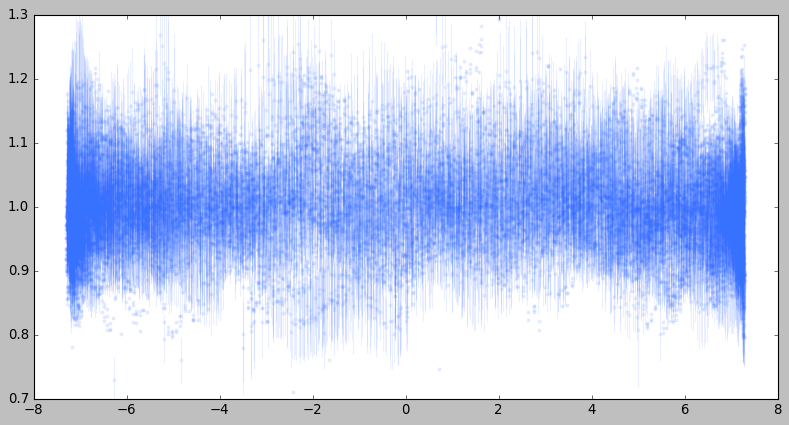

In [12]:
data171 = np.genfromtxt("./heliocentricLat_171_corrected_2008onwards.txt")
print(np.shape(data171))
fig, ax = plt.subplots(1,1,figsize=(12,6))
ax.errorbar(data171[:,0],data171[:,1],data171[:,2],marker='.',elinewidth=1,capsize=0,linestyle='None',color='#3772ff',alpha=0.1)
ax.set_ylim(0.7,1.3)
plt.show()

In [3]:
# Define the dimensionality of our problem.
ndim = 3

# Define our 3-D correlated multivariate normal likelihood.
C = np.identity(ndim)  # set covariance to identity matrix
C[C==0] = 0.95  # set off-diagonal terms
Cinv = np.linalg.inv(C)  # define the inverse (i.e. the precision matrix)
lnorm = -0.5 * (np.log(2 * np.pi) * ndim +
                np.log(np.linalg.det(C)))  # ln(normalization)

def loglike(x):
    """The log-likelihood function."""

    return -0.5 * np.dot(x, np.dot(Cinv, x)) + lnorm

# Define our uniform prior.
def ptform(u):
    """Transforms samples `u` drawn from the unit cube to samples to those
    from our uniform prior within [-10., 10.) for each variable."""

    return 10. * (2. * u - 1.)

In [4]:
# "Static" nested sampling.
sampler = dynesty.NestedSampler(loglike, ptform, ndim)
sampler.run_nested()
sresults = sampler.results

# "Dynamic" nested sampling.
dsampler = dynesty.DynamicNestedSampler(loglike, ptform, ndim)
dsampler.run_nested()
dresults = dsampler.results


4721it [00:00, 5057.84it/s, +500 | bound: 8 | nc: 1 | ncall: 23577 | eff(%): 22.624 | loglstar:   -inf < -0.298 <    inf | logz: -8.955 +/-  0.128 | dlogz:  0.001 >  0.509]
15120it [00:03, 4610.58it/s, batch: 7 | bound: 4 | nc: 1 | ncall: 39024 | eff(%): 38.494 | loglstar: -5.585 < -0.302 < -1.131 | logz: -8.975 +/-  0.075 | stop:  0.933]             


In [5]:
from dynesty import utils as dyfunc

# Combine results from "Static" and "Dynamic" runs.
results = dyfunc.merge_runs([sresults, dresults])

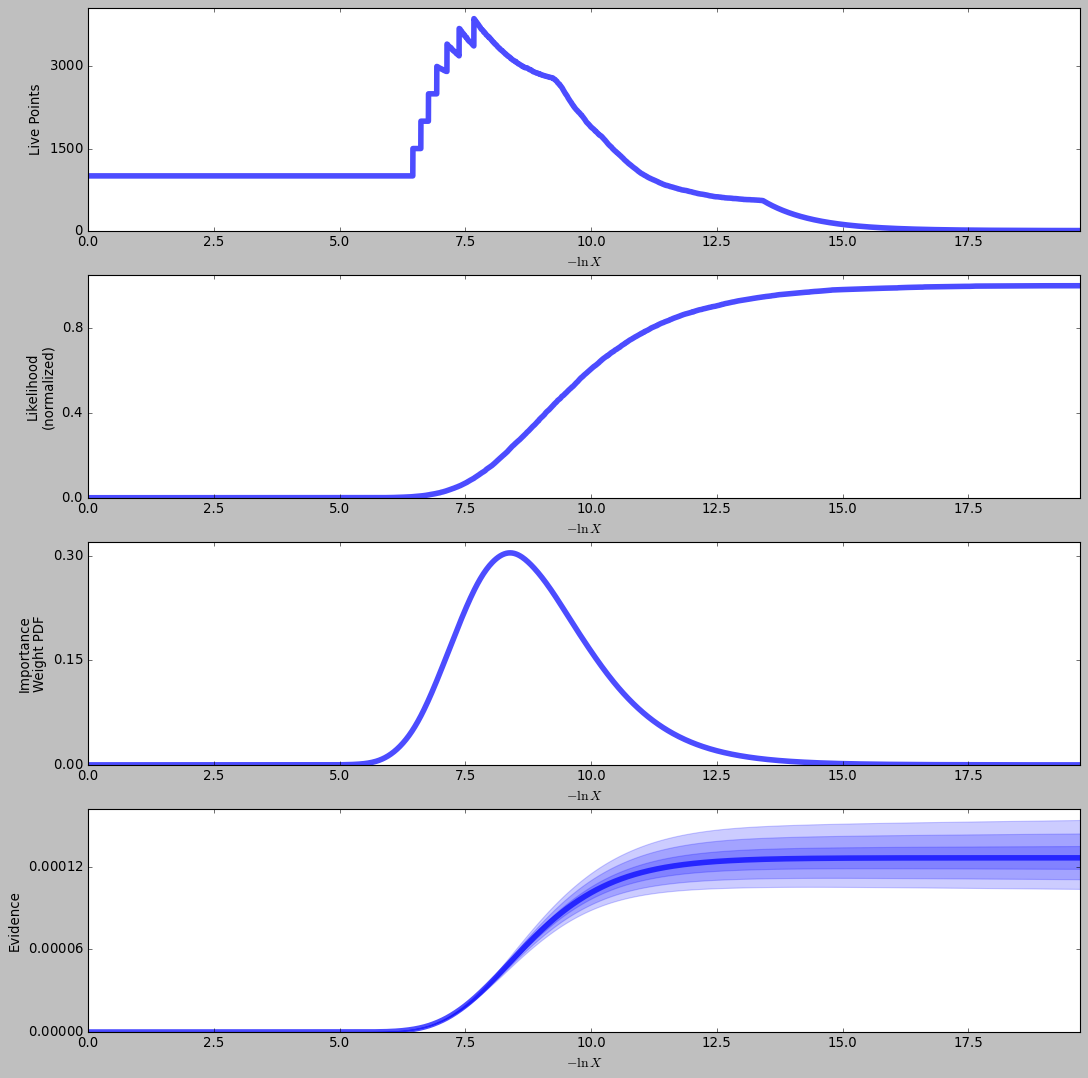

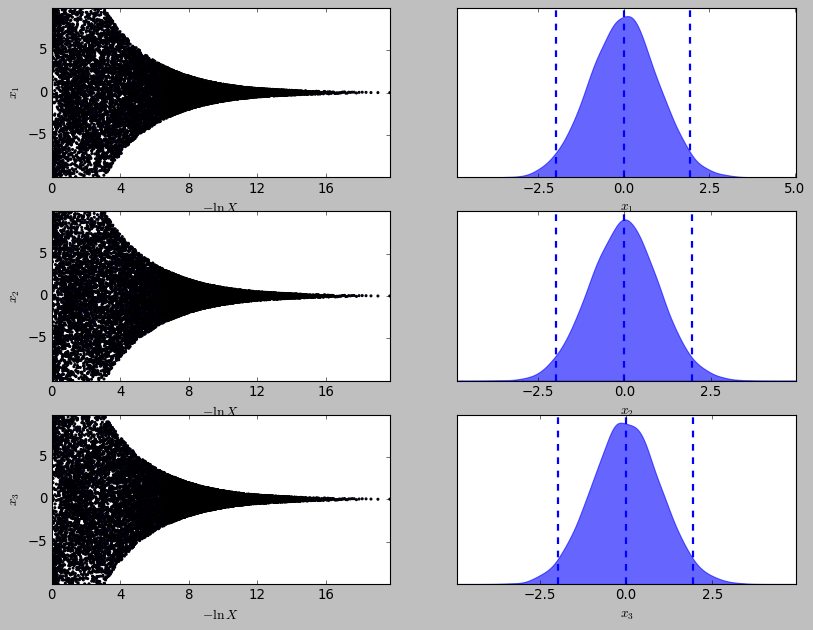

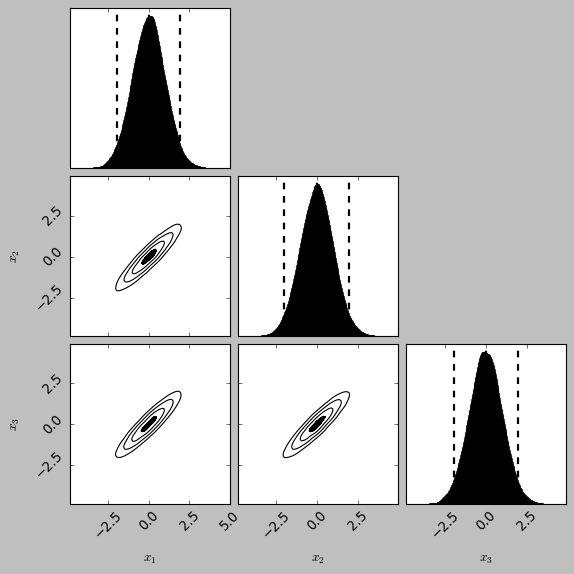

In [6]:
from dynesty import plotting as dyplot

# Plot a summary of the run.
rfig, raxes = dyplot.runplot(results)

# Plot traces and 1-D marginalized posteriors.
tfig, taxes = dyplot.traceplot(results)

# Plot the 2-D marginalized posteriors.
cfig, caxes = dyplot.cornerplot(results)


In [7]:
from dynesty import utils as dyfunc

# Extract sampling results.
samples = results.samples  # samples
weights = results.importance_weights()

# Compute 10%-90% quantiles.
quantiles = [dyfunc.quantile(samps, [0.1, 0.9], weights=weights)
             for samps in samples.T]

# Compute weighted mean and covariance.
mean, cov = dyfunc.mean_and_cov(samples, weights)

# Resample weighted samples.
samples_equal = results.samples_equal()

# Generate a new set of results with sampling uncertainties.
results_sim = dyfunc.resample_run(results)
